<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Simple_Bayesian_Change_Point_Detection_with_Pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Change-Point Detection in Pymc3

## Problem Setup

### Import Packages

In [78]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Styling
%matplotlib inline
plt.style.use('fivethirtyeight')

### Generate Data

The code below generates a Gaussian timeseries with 20 observations and a shift in mean from 0 to 5 at the 10th timestep.  Additionally, it has standard deviation 2.5, making it fairly challenging for a changepoint detection system.

In [79]:
y1 = np.random.normal(0,2.5,10)
y2 = np.random.normal(5,2.5,10)
y = np.append(y1,y2)

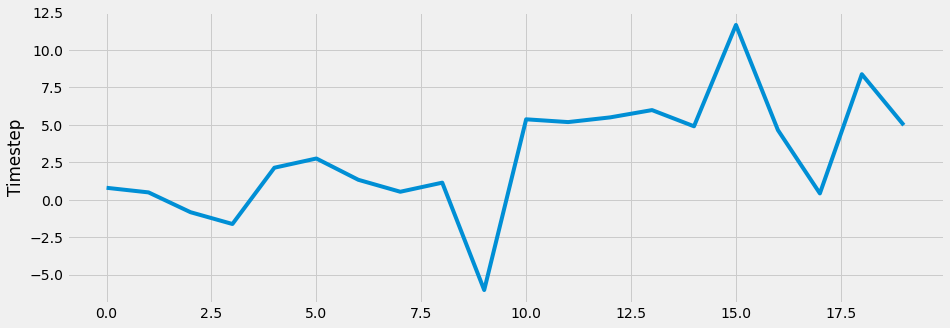

In [80]:
plt.figure(figsize=(14,5))
plt.plot(y)
plt.ylabel('Timestep')
plt.show()

## Build Model

Below, a model object is constructed and used under the alias "model".  Then, the prior distributions are defined.  First, "Beta" is defined as two Uniform random variables with lower and upper bounds equal to the min and max of the dataset, which will be estimated as the mean (before and after change) of the final model.

Next, sigma is defined as a HalfNormal random variable as it must be positive.  Worth noting, it is defined for the entire model, whether before or after a changepoint and assumes stable variance through the changes.  

Following sigma, changepoint is defined as a DiscreteUniform random variable with upper and lower bounds zero and length of timeseries since all the timesteps can be considered and are discrete.  

After, the switch function is initialized as Deterministic since it only contains inherited uncertainty. It is operates as a function making both betas available to the changepoint parameter.  

Next, the final model is established as a random Normal variable with mean and standard deviation being set by the priors and/or thier optimized posteriors.  It is bound to the observed data (y).

Finally, trace samples from the model to optimize its parameters, and then provides a set of sampled data as a posterior distribution for further use.  For additional analysis, MAP is estimated.

In [81]:
ts_length = len(y)
min = y.min()
max = y.max()

with pm.Model() as model:

    # Priors
    beta = pm.Uniform('beta', lower=min, upper=max, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    changepoint = pm.DiscreteUniform("changepoint", lower=0, upper=ts_length)

    # Switch Function
    mu = pm.Deterministic('mu', pm.math.switch(changepoint > np.arange(ts_length), beta[0], beta[1]))

    # Model
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sample Posterior Distribution
    trace = pm.sample(10000, chains=2, return_inferencedata=True)

    # Find Maximum Posteriori Estimate (mode of parameter distributions)
    MAP_ = pm.find_MAP()

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigma, beta]
>Metropolis: [changepoint]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Evaluate Model and Analyze Performance

### View Model as Bayesian Graphical Model

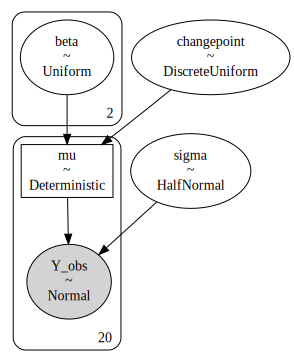

In [82]:
pm.model_to_graphviz(model)

### Summary Statistics for Model Parameters

The summary show that beta[0] and beta[1] were reasonably close to the actual pre- and post-change means of 0 and 5, respectively.  Additionally, the changepoint was picked up with incredible accuracy, as the pmf's mean was only 0.185 timesteps off the correct point of 10. Also, it's standard deviation was 0.572, which expresses a small degree of uncertainty about this parameter.

In [83]:
az.summary(trace, kind='stats', var_names=['beta','sigma','changepoint'])

,mean,sd,hdi_3%,hdi_97%
beta[0],0.169,0.822,-1.402,1.694
beta[1],5.712,0.812,4.212,7.234
sigma,2.462,0.341,1.863,3.112
changepoint,10.185,0.572,10.000,11.000


### Maximum A Posteriori Probability (MAP)

10 was selected for the change point, which is correct.  Additionally, the estimation of both beta parameters was closer to the true value than their respective means.  However, the estimated sigma value is further off than the mean by almost 0.2 stds.

In [93]:
pd.DataFrame( {'Parameter': ['beta[0]', 'beta[1]','changepoint', 'sigma'],
    'Value':[MAP_['beta'][0], MAP_['beta'][1], MAP_['changepoint'], MAP_['sigma']]})

,Parameter,Value
0,beta[0],0.0768804
1,beta[1],5.70821
2,changepoint,10
3,sigma,2.2677542891432574


### Plot Posterior Distributions

The posteriors look good and reinforce the numerical results.  Additionally, they show that both betas are roughly normally distributed and that sigma is close to normal except for its long tail.  Even more interesting is the changepoint distribution, which shows the correct answer (10) is the most probabable and that only a small amount of weight was shifted to 11 and 12, respectively.

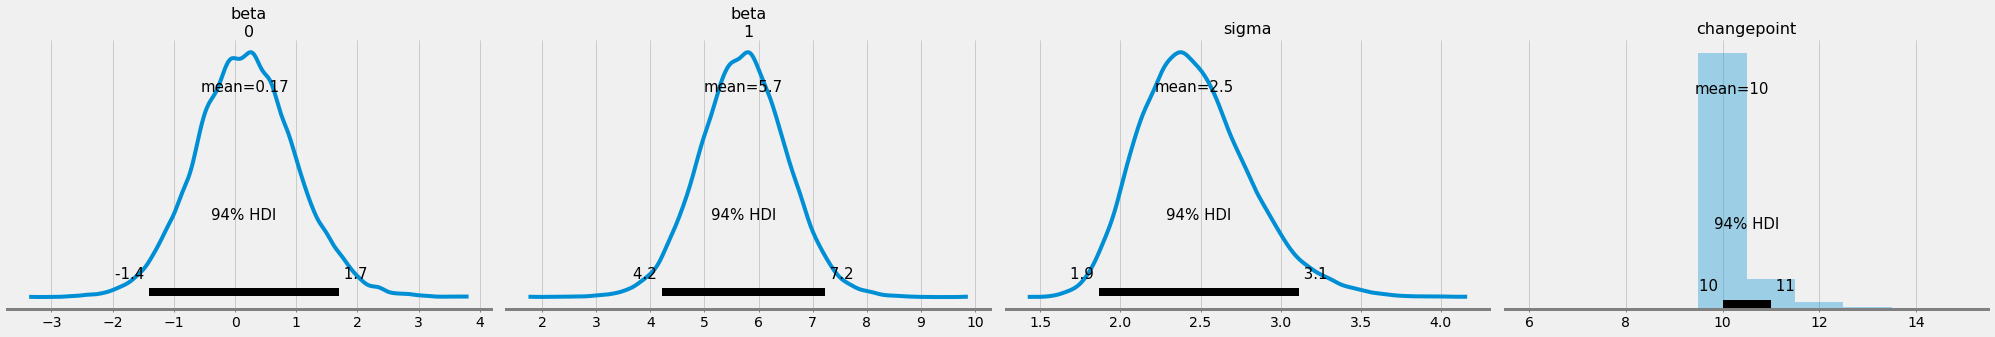

In [92]:
az.plot_posterior(trace, var_names=['beta','sigma','changepoint'])
plt.show()

## Conclusion

The model performed well.  It was able to detect the changepoint with a decisive level of certainty amidst a substantial amount of noise.

In future versions of this model, sigma could be duplicated to cover situations where it shifts with beta.  Additionally, a user parameter allowing for more betas (i.e. more changepoints) would also be useful, since so many timeseries have multiple interventions/changes influencing them simultaneously.

In future versions of this notebook, it might be beneficial to the reader to show how to compute the likelihood of a changepoint on a given day or within a given range.  Technically, it is easy once the posterior distribution has been accurately estimated.

## Appendix 1 -- Generate New Time Series Data with Model

### Get Sample of Posterior

In [87]:
with model:
  pp = pm.sample_posterior_predictive(trace)

### Plot a Few of the Generated Timeseries

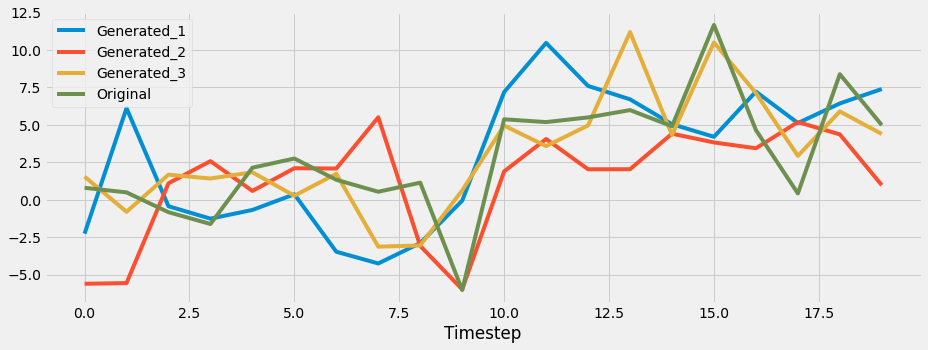

In [88]:
plt.figure(figsize=(14,5))
for i in range(3):
  plt.plot(pp['Y_obs'][i])
plt.xlabel('Timestep')
plt.plot(y)
plt.legend(['Generated_1','Generated_2','Generated_3','Original'])
plt.show()

## Appendix 2 -- Bootstrap for Confidence Intervals and Posterior Mean (Plotted)

### Get mean and std for each timestep from posterior sample to use in plot.

In [89]:
y_mean = pp['Y_obs'].mean(axis=0)
sigma = pp['Y_obs'].std(axis=0)
x = np.linspace(1,20,20)

### Plot Mean and 95% Confidence Band of Posterior

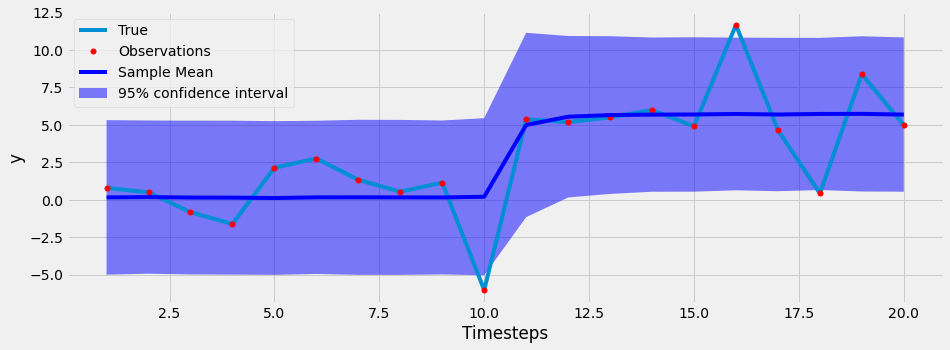

In [90]:
# Borrowed from Sklearn Documentation: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

plt.figure(figsize=(14,5))
plt.plot(x, y,  label=r'True')
plt.plot(x, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_mean, 'b-', label='Sample Mean')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('Timesteps')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()